In [42]:
# %run utils.ipynb

In [60]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import talib as ta2
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
from datetime import timedelta as delta
import numpy as np
import os
import seaborn as sb

%matplotlib inline

In [51]:
nifty_50_stocks = ['EICHERMOT','HEROMOTOCO','NESTLEIND','ONGC','BAJAJ-AUTO','TATASTEEL','GRASIM',
                   'BRITANNIA','BAJFINANCE','DIVISLAB','M&M','HINDUNILVR','HDFCBANK','HDFCLIFE','BHARTIARTL','TCS',
                   'LT','DRREDDY','ULTRACEMCO','SUNPHARMA','NTPC','TATAMOTORS','UPL','SBIN','HINDALCO','ITC','JSWSTEEL',
                   'COALINDIA','RELIANCE','BPCL','LTIM','MARUTI','HCLTECH','POWERGRID','WIPRO','SBILIFE','AXISBANK',
                   'ADANIPORTS','ICICIBANK','TITAN','BAJAJFINSV','KOTAKBANK','TATACONSUM','APOLLOHOSP','INFY','ASIANPAINT',
                   'ADANIENT','INDUSINDBK','TECHM','CIPLA']

In [52]:
signals = pd.DataFrame({
    '10_cross_30':[0,0,1,1,1],
    'MACD_Signal_MACD':[1,1,1,0,0],
    'MACD_lim':[0,0,0,1,1],
    'abv_50':[1,1,1,0,0],
    'abv_200':[0,1,0,0,1],
    'strategy': [1,2,3,4,5],
})

signals

,10_cross_30,MACD_Signal_MACD,MACD_lim,abv_50,abv_200,strategy
0,0,1,0,1,0,1
1,0,1,0,1,1,2
2,1,1,0,1,0,3
3,1,0,1,0,0,4
4,1,0,1,0,1,5


In [53]:
def add_signal_indicators(df):
    df['SMA_10'] = ta.sma(df['Adj Close'],length=10)
    df['SMA_30'] = ta.sma(df['Adj Close'],length=30)
    df['SMA_50'] = ta.sma(df['Adj Close'],length=50)
    df['SMA_200'] = ta.sma(df['Adj Close'],length=200)
    
    macd = ta.macd(df['Adj Close'], fast=12, slow=26, signal=9)
    df['MACD'] = macd['MACD_12_26_9']
    df['MACD_signal'] = macd['MACDs_12_26_9']
    df['MACD_hist'] = macd['MACDh_12_26_9']

    df['10_cross_30'] = np.where(df['SMA_10'] > df['SMA_30'], 1, 0)
    df['MACD_Signal_MACD'] = np.where(df['MACD_signal'] < df['MACD'], 1, 0)
    df['MACD_lim'] = np.where(df['MACD']>0, 1, 0)
    df['abv_50'] = np.where((df['SMA_30']>df['SMA_50'])&(df['SMA_10']>df['SMA_50']), 1, 0)
    df['abv_200'] = np.where((df['SMA_30']>df['SMA_200'])&(df['SMA_10']>df['SMA_200'])&(df['SMA_50']>df['SMA_200']), 1, 0)
    
    return df

In [54]:
signals.columns[:-1]

Index(['10_cross_30', 'MACD_Signal_MACD', 'MACD_lim', 'abv_50', 'abv_200'], dtype='object')

In [55]:
def backtest_signals(row):
    global TRADES, trade_in_progress, signals, holding_period
    
    if(trade_in_progress):
        _data = TRADES[-1]
        # time to sell after n holding days
        if(row['index']==_data['sell_index']):
            _data['sell_price'] = round(row['Adj Close'],2)
            _data['sell_date'] = str(pd.to_datetime(row['Date']).date())
            _data['returns'] = round((_data['sell_price']-_data['buy_price'])/_data['buy_price']*100, 3)
            TRADES[-1] = _data
            trade_in_progress = False
            
    else:
        _r = pd.DataFrame([row])
        _r = _r.merge(signals, on=list(signals.columns[:-1]), how='inner')
        strategy = _r.shape[0]
        
        if(strategy>0): 
            trade_in_progress = True
            TRADES.append({
                'strategy': _r['strategy'].values[0],
                'buy_date': str(pd.to_datetime(row['Date']).date()),
                'buy_index': row['index'],
                'sell_date': '',
                'sell_index': row['index'] + holding_period,
                'buy_price': round(row['Adj Close'], 2),
                'sell_price': '',
                'returns': 0,
                'stock': row['stock']
            })


In [56]:
TRADES = []
trade_in_progress = False
holding_period = 14

for i in nifty_50_stocks:
    print('testing ', i)
    _df = yf.download(f"{i}.NS", 
                      period='1d', 
                      start='2000-01-01', 
                      end=(dt.now() + delta(1)).strftime('%Y-%m-%d'), 
                      progress=False)

    _df = add_signal_indicators(_df)

    _df['stock'] = i
    _df.reset_index().reset_index().apply(backtest_signals, axis=1)
    print(f'done performing backtesting for {i}')
    del _df
    trade_in_progress = False

testing  EICHERMOT
done performing backtesting for EICHERMOT
testing  HEROMOTOCO
done performing backtesting for HEROMOTOCO
testing  NESTLEIND
done performing backtesting for NESTLEIND
testing  ONGC
done performing backtesting for ONGC
testing  BAJAJ-AUTO
done performing backtesting for BAJAJ-AUTO
testing  TATASTEEL
done performing backtesting for TATASTEEL
testing  GRASIM
done performing backtesting for GRASIM
testing  BRITANNIA
done performing backtesting for BRITANNIA
testing  BAJFINANCE
done performing backtesting for BAJFINANCE
testing  DIVISLAB
done performing backtesting for DIVISLAB
testing  M&M
done performing backtesting for M&M
testing  HINDUNILVR
done performing backtesting for HINDUNILVR
testing  HDFCBANK
done performing backtesting for HDFCBANK
testing  HDFCLIFE
done performing backtesting for HDFCLIFE
testing  BHARTIARTL
done performing backtesting for BHARTIARTL
testing  TCS
done performing backtesting for TCS
testing  LT
done performing backtesting for LT
testing  DRRE

In [72]:
TRADES[35:40]

[{'strategy': 4,
  'buy_date': '2016-02-29',
  'buy_index': 3405,
  'sell_date': '2016-03-21',
  'sell_index': 3419,
  'buy_price': 1935.66,
  'sell_price': 2198.79,
  'returns': 13.594,
  'stock': 'HEROMOTOCO'},
 {'strategy': 2,
  'buy_date': '2017-04-25',
  'buy_index': 3687,
  'sell_date': '2017-05-16',
  'sell_index': 3701,
  'buy_price': 2662.28,
  'sell_price': 2915.36,
  'returns': 9.506,
  'stock': 'HEROMOTOCO'},
 {'strategy': 4,
  'buy_date': '2018-01-11',
  'buy_index': 3867,
  'sell_date': '2018-02-01',
  'sell_index': 3881,
  'buy_price': 3009.13,
  'sell_price': 3031.3,
  'returns': 0.737,
  'stock': 'HEROMOTOCO'},
 {'strategy': 4,
  'buy_date': '2018-03-19',
  'buy_index': 3911,
  'sell_date': '2018-04-10',
  'sell_index': 3925,
  'buy_price': 2898.89,
  'sell_price': 3066.3,
  'returns': 5.775,
  'stock': 'HEROMOTOCO'},
 {'strategy': 4,
  'buy_date': '2018-06-25',
  'buy_index': 3978,
  'sell_date': '2018-07-13',
  'sell_index': 3992,
  'buy_price': 2957.9,
  'sell_price

C:\Users\alarv\AppData\Local\Temp\ipykernel_12668\2375210215.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


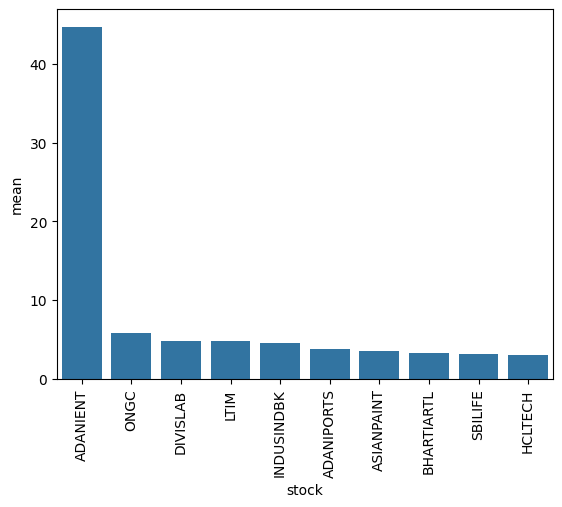

In [69]:
x = pd.DataFrame(TRADES)

pos = x.groupby('stock')['returns'].agg(['mean']).reset_index()
pos = pos.sort_values(by='mean', ascending=False).head(10)

ax = sb.barplot(x='stock', y='mean', data=pos)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

C:\Users\alarv\AppData\Local\Temp\ipykernel_12668\2308941727.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


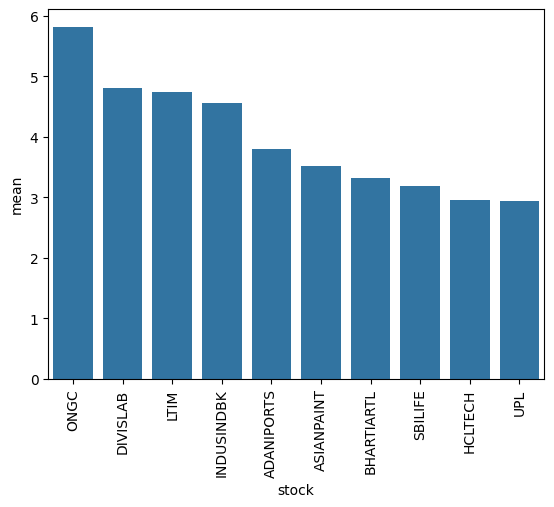

In [68]:
x = pd.DataFrame(TRADES)

pos = x.groupby('stock')['returns'].agg(['mean']).reset_index()
pos = pos.sort_values(by='mean', ascending=False).head(11).tail(10)

ax = sb.barplot(x='stock', y='mean', data=pos)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

C:\Users\alarv\AppData\Local\Temp\ipykernel_12668\2070347892.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


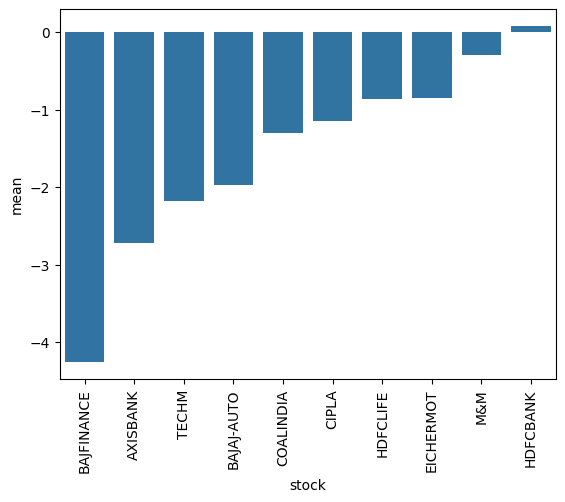

In [70]:
pos = pd.DataFrame(TRADES).groupby('stock')['returns'].agg(['mean']).reset_index()
pos = pos.sort_values(by='mean', ascending=True).head(10)
ax = sb.barplot(x='stock', y='mean', data=pos)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [57]:
pd.DataFrame(TRADES).groupby('stock')['returns'].agg(['mean','median','sum','count']).reset_index()

,stock,mean,median,sum,count
0,ADANIENT,44.747947,0.4660,850.211,19
1,ADANIPORTS,3.795389,3.9600,68.317,18
2,APOLLOHOSP,1.001912,0.4725,34.065,34
3,ASIANPAINT,3.514474,0.6610,66.775,19
4,AXISBANK,-2.723000,-3.8400,-68.075,25
5,BAJAJ-AUTO,-1.969357,0.0065,-27.571,14
6,BAJAJFINSV,1.159562,-0.2230,18.553,16
7,BAJFINANCE,-4.255727,-5.3200,-46.813,11
8,BHARTIARTL,3.324038,3.0020,86.425,26
9,BPCL,2.789696,3.9180,64.163,23
